In [88]:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [89]:

def find_file(directory, file_name):
    """
    Searches for a specific file within a directory and its subdirectories.

    Args:
        directory (str): The directory to search in.
        file_name (str): The name of the file to find.

    Returns:
        str: Full path to the file if found, otherwise None.
    """
    for root, _, files in os.walk(directory):
        if file_name in files:
            return os.path.join(root, file_name)
    return None

def search_and_concatenate_csvs_with_animal_id(root_dir, filename="rec_info.csv", settings_file="settings.xml", prob_file="prob_df.csv",cluster_filename="cluster_info.tsv"):
    """
    Searches for CSV files with the specified filename in subdirectories of the given root directory,
    adds "Animal_ID", "Recording_Date", channel positions, and other metadata columns,
    and concatenates all files into one DataFrame.

    Args:
        root_dir (str): The root directory to start the search.
        filename (str): The name of the file to search for (default: "rec_info.csv").
        settings_file (str): The name of the settings file to find recording date (default: "settings.xml").
        prob_file (str): The name of the file containing channel position data (default: "prob_df.csv").

    Returns:
        pd.DataFrame: A concatenated DataFrame containing data from all found files with the added metadata columns.
    """
    # List to store dataframes
    dataframes = []
    cluster_dataframes = []
    implantation_dates = datetime.date(2024, 7, 19)
    previous_date = {}
    # Walk through all subdirectories
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file == filename:
                # Construct full file path for rec_info.csv
                file_path_rec_info = os.path.join(subdir, file)
                # Path to cluster_info.tsv
                cluster_file_path = os.path.join(subdir, 'ks4phy_autocurated', cluster_filename)

                # Extract metadata from the directory structure
                input_string = os.path.basename(os.path.dirname(subdir))  # Parent folder name
                split_parts = input_string.split("_")
                try:
                    day_rec, sessions, shank = split_parts
                except ValueError:
                    print(f"Error parsing directory structure: {input_string}")
                    continue

                # Extract Animal_ID from parent of the parent directory
                animal_id = os.path.basename(os.path.dirname(os.path.dirname(subdir)))  # Parent of parent folder name

                # Find settings.xml in the current subdir
                settings_file_path = find_file(subdir, settings_file)
                if settings_file_path:
                    # Get the modification time as the recording date
                    creation_time = os.path.getmtime(settings_file_path)
                    recording_date = datetime.datetime.fromtimestamp(creation_time).date()
                    
                else:
                    # print(f"Settings file '{settings_file}' not found in {subdir}.")
                    recording_date = None

                # Resolve duplicate recording dates for the same animal
                if recording_date == previous_date:
                    recording_date += datetime.timedelta(days=1)  # Increment by 1 day
                previous_date = recording_date
                day_from_recording = (recording_date - implantation_dates).days

                # Find prob_df.csv in the current subdir
                prob_file_path = find_file(subdir, prob_file)
                if prob_file_path:
                    try:
                        prob_df = pd.read_csv(prob_file_path)
                        # Extract minimum x and y values for channel positions
                        chan_locX = prob_df['x'].min()
                        chan_locY = prob_df['y'].min()
                    except Exception as e:
                        # print(f"Error reading {prob_file_path}: {e}")
                        chan_locX, chan_locY = None, None
                else:
                    # print(f"Probe file '{prob_file}' not found in {subdir}.")
                    chan_locX, chan_locY = None, None

                # print(f"Found file: {file_path_rec_info} | Animal ID: {animal_id} | Recording Date: {recording_date} | Channel LocX: {chan_locX} | Channel LocY: {chan_locY}")
                try:
                    # Load CSV into DataFrame
                    df = pd.read_csv(file_path_rec_info)

                    # Add metadata columns
                    df.insert(0, 'Animal_ID', animal_id)  # Insert Animal_ID as the first column
                    df.insert(1, 'Recording_Date', recording_date)  # Insert Recording_Date as the second column
                    df['sessions'] = sessions
                    df['rec_day'] = day_rec
                    df['shank_bank'] = shank
                    df['chan_locX'] = chan_locX
                    df['chan_locY'] = chan_locY
                    df['Days_From_Implantation'] = day_from_recording

                    # Append DataFrame to the list
                    dataframes.append(df)
                    
                    # Load the cluster_info file
                    cluster_df = pd.read_csv(cluster_file_path, sep='\t')
                    cluster_df['Animal_ID'] = animal_id
                    cluster_df['Recording_Date'] = recording_date
                    cluster_df['Days_From_Implantation'] = day_from_recording
                    cluster_df['shank_bank'] = shank
                    cluster_df['chan_locX'] = chan_locX
                    cluster_df['chan_locY'] = chan_locY
                    cluster_dataframes.append(cluster_df)

                
                except Exception as e:
                    print(f"Error reading {file_path_rec_info}: {e}")

    # Concatenate all DataFrames if any found
    if dataframes:
        concatenated_df = pd.concat(dataframes, ignore_index=True)
        concatenated_cluster_df = pd.concat(cluster_dataframes, ignore_index=True)
        print("Successfully concatenated all files.")
        return concatenated_df,concatenated_cluster_df
    else:
        print(f"No files named '{filename}' found.")
        return pd.DataFrame()  # Return empty DataFrame if no files found
#########################################################################

# Specify the root directory
root_directory = "D:/ephys/NPX2"
concatenated_df,concatenated_cluster_df = search_and_concatenate_csvs_with_animal_id(root_directory)
concatenated_df = concatenated_df.drop(columns=['rec_date'])

# save the result
# concatenated_data.to_csv("output_with_animal_id_and_recording_date.csv", index=False)


Successfully concatenated all files.


In [90]:
concatenated_cluster_df

,cluster_id,amp,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,ch,channel_group,depth,firing_range,...,snr,sync_spike_2,sync_spike_4,sync_spike_8,Animal_ID,Recording_Date,Days_From_Implantation,shank_bank,chan_locX,chan_locY
0,0,18.677490,0.000084,0.860401,0.437103,-4.875000,238,0,2895.0,2.6,...,1.232788,0.044885,0.000228,0.000228,Fa0156,2024-08-22,34,Shank4BankB,750.0,2880.0
1,1,16.838253,0.000164,0.805259,0.343302,-5.655000,258,0,3045.0,2.4,...,1.203274,0.068153,0.000507,0.000000,Fa0156,2024-08-22,34,Shank4BankB,750.0,2880.0
2,2,16.432648,0.037695,0.424353,0.161262,-10.140000,258,0,3045.0,2.8,...,2.175739,0.038444,0.001853,0.000232,Fa0156,2024-08-22,34,Shank4BankB,750.0,2880.0
3,3,16.257151,0.152926,0.363837,1.247324,-10.724999,280,0,3210.0,1.4,...,2.430845,0.041038,0.003018,0.001811,Fa0156,2024-08-22,34,Shank4BankB,750.0,2880.0
4,4,11.286601,0.000050,1.156841,0.565364,-3.705000,281,0,3225.0,3.2,...,0.900011,0.071754,0.000939,0.000000,Fa0156,2024-08-22,34,Shank4BankB,750.0,2880.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4929,176,19.387291,0.000785,0.344022,0.201047,-15.210000,279,0,2460.0,0.8,...,4.025050,0.060914,0.000000,0.000000,FA1680378B,2024-08-14,26,Shank3BankA,500.0,0.0
4930,177,63.462769,0.003914,NaN,NaN,-14.820000,333,0,2520.0,4.4,...,3.906582,0.090013,0.000329,0.000000,FA1680378B,2024-08-14,26,Shank3BankA,500.0,0.0
4931,178,53.513847,0.000188,NaN,NaN,-12.285000,333,0,2520.0,6.4,...,3.286893,0.069057,0.000312,0.000000,FA1680378B,2024-08-14,26,Shank3BankA,500.0,0.0
4932,179,101.378532,0.014729,NaN,NaN,-59.864998,341,0,2580.0,2.6,...,15.382175,0.082353,0.000000,0.000000,FA1680378B,2024-08-14,26,Shank3BankA,500.0,0.0


In [91]:
concatenated_df

,Animal_ID,Recording_Date,mean_chan_noise,chan_locX,chan_locY,sessions,rec_day,shank_bank,Days_From_Implantation
0,Fa0156,2024-08-22,4.798355,750.0,2880.0,CntrlRotNoRot,Day10,Shank4BankB,34
1,Fa0156,2024-07-27,5.373389,0.0,0.0,CntrlCntrlZero,Day1,Shank1BankA,8
2,Fa0156,2024-07-30,5.747686,0.0,0.0,CntrlCntrl,Day2,Shank1BankA,11
3,Fa0156,2024-08-03,5.743563,0.0,0.0,CntrlNoRotRotCntrlZero,Day3,Shank1BankA,15
4,Fa0156,2024-08-04,4.332640,0.0,2880.0,CntrlCntrlZero,Day4,Shank1BankB,16
5,Fa0156,2024-08-05,4.445290,0.0,2880.0,CntrlCntrlZero,Day5,Shank1BankB,17
6,Fa0156,2024-08-09,4.699501,750.0,0.0,CntrlRotNORot,Day6,Shank4BankA,21
7,Fa0156,2024-08-11,4.703943,750.0,0.0,CntrlCntrl,Day7,Shank4BankA,23
8,Fa0156,2024-08-19,4.777669,500.0,0.0,CntrlNoRotRot,Day8,Shank3BankA,31
9,Fa0156,2024-08-20,4.674449,500.0,0.0,CntrlCntrlCntrl,Day9,Shank3BankA,32


In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cluster_metrics_per_day(cluster_df, animal_id, output_file="cluster_metrics"):
    """
    Plots boxplots for SNR, Amplitude, and Firing Rate grouped by 'Days_From_Implantation',
    sorted numerically, and colored based on 'shank_bank'.

    Args:
        cluster_df (pd.DataFrame): DataFrame containing cluster data.
        animal_id (str): Animal ID to filter and plot.
        output_file (str): Output file name to save the figure.
    """
    output_file= os.path.join(root_directory,animal_id+'_'+output_file)
    # Filter data for the given animal ID and excluding noise units
    animal_data = cluster_df[(cluster_df['Animal_ID'] == animal_id) & (cluster_df['group'] != 'noise')]

    if animal_data.empty:
        print(f"No data available for Animal ID: {animal_id}")
        return

    # Sort the data by 'Days_From_Implantation' to ensure sorted boxplots
    animal_data = animal_data.sort_values(by='Days_From_Implantation')

    # Convert 'Days_From_Implantation' to a categorical variable with ordered days
    animal_data['Days_From_Implantation'] = pd.Categorical(
        animal_data['Days_From_Implantation'], ordered=True
    )

    # Plot boxplots
    sns.set(style="white")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Cluster Metrics for {animal_id}")

    # SNR
    sns.boxplot(
        data=animal_data,
        x='Days_From_Implantation',
        y='snr',
        hue='shank_bank',
        ax=axes[0]
    )
    # axes[0].set_title('SNR per Day')
    axes[0].set_xlabel('Days from Implantation')
    axes[0].set_ylabel('SNR')
    axes[0].grid(False)  # Remove grid
    # axes[0].set_frame_on(False)
    leg = axes[0].get_legend() 
    leg.set_frame_on(False)

    # Amplitude
    sns.boxplot(
        data=animal_data,
        x='Days_From_Implantation',
        y='amp',
        hue='shank_bank',
        ax=axes[1]
    )
    # axes[1].set_title('Amplitude per Day')
    axes[1].set_xlabel('Days from Implantation')
    axes[1].set_ylabel('Amplitude (uV)')
    axes[1].grid(False)  # Remove grid
    # axes[1].set_frame_on(False)
    leg = axes[1].get_legend() 
    leg.set_frame_on(False)
                     
    # Firing Rate
    sns.boxplot(
        data=animal_data,
        x='Days_From_Implantation',
        y='fr',
        hue='shank_bank',
        ax=axes[2]
    )
    # axes[2].set_title('Firing Rate per Day')
    axes[2].set_xlabel('Days from Implantation')
    axes[2].set_ylabel('Firing Rate (spike/sec)')
    axes[2].grid(False)  # Remove grid
    # axes[2].set_frame_on(False)
    leg = axes[2].get_legend() 
    leg.set_frame_on(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figure 
    plt.savefig(output_file+'.pdf', format='pdf')
    plt.savefig(output_file+'.png', format='png')
    plt.show()


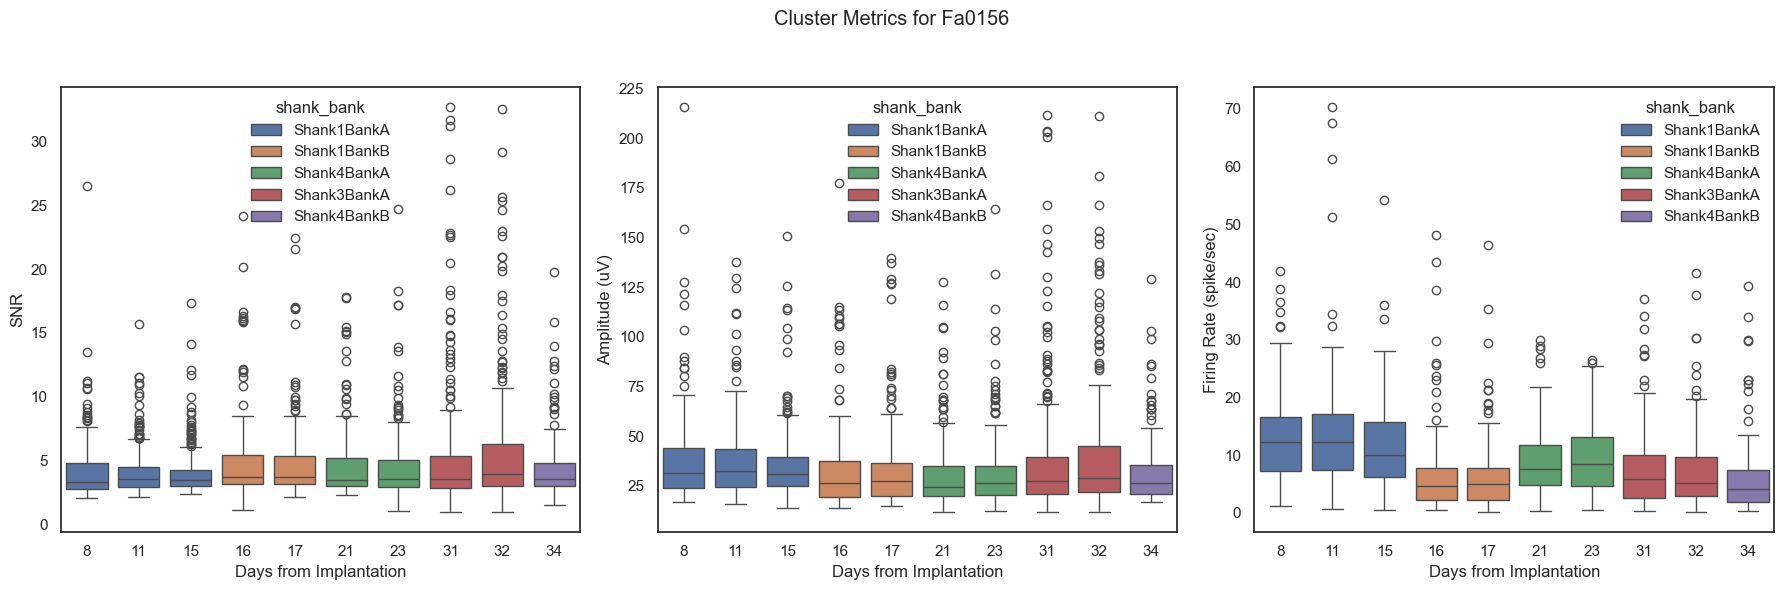

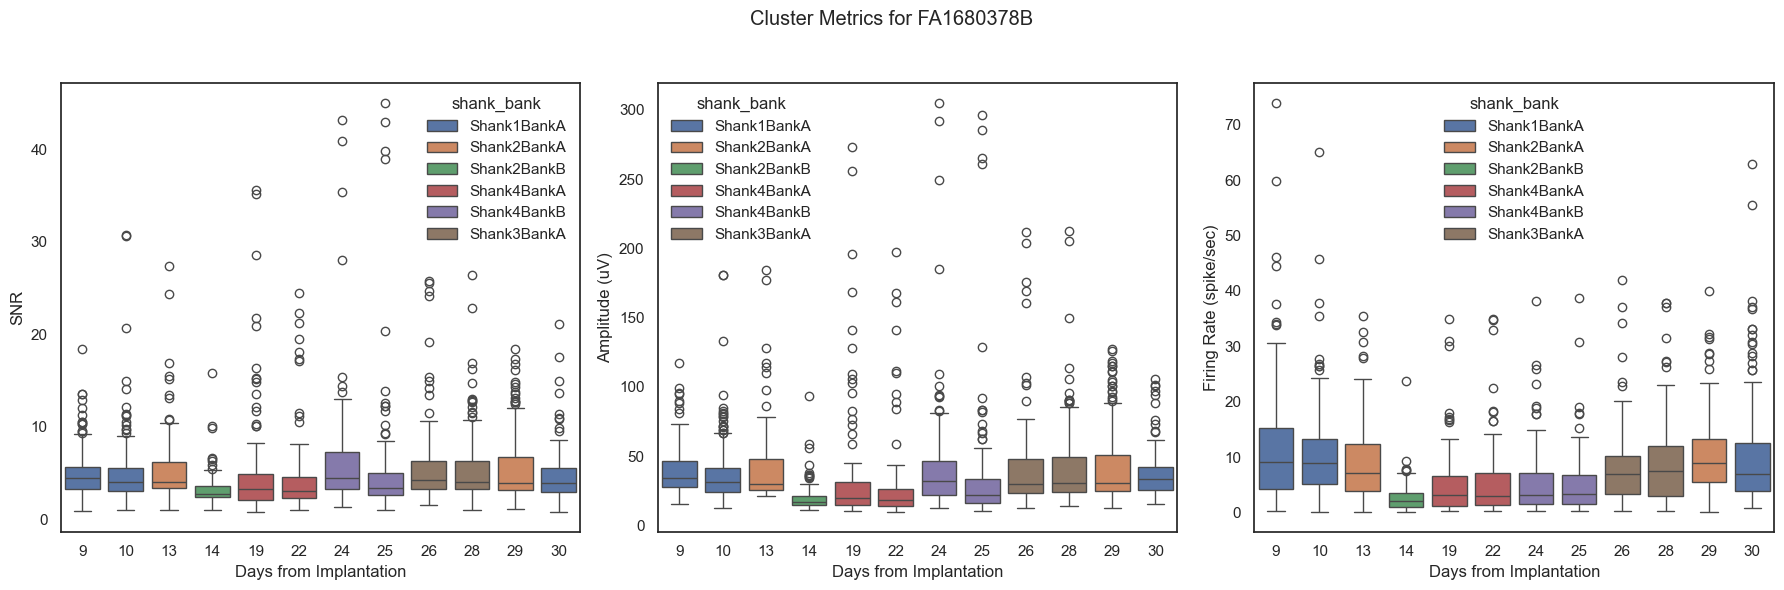

In [93]:
for animal in concatenated_cluster_df['Animal_ID'].unique():
            plot_cluster_metrics_per_day(concatenated_cluster_df, animal)

C:\Users\saeedi\AppData\Local\Temp\ipykernel_24136\4002463420.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


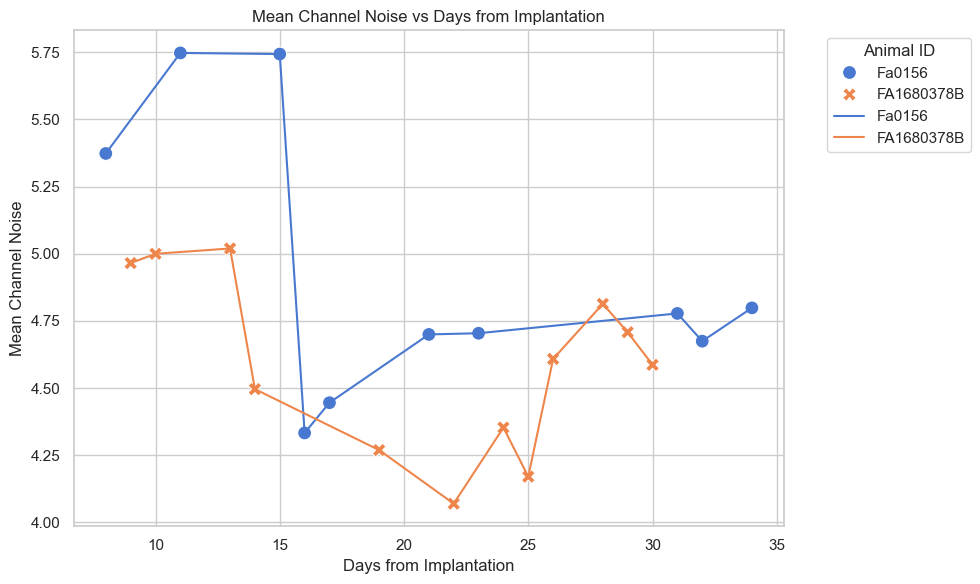

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the DataFrame by Days_From_Implantation
concatenated_df = concatenated_df.sort_values(by="Days_From_Implantation")

# Set Seaborn style and palette
sns.set(style="whitegrid", palette="muted")

# Create a scatter plot for mean_chan_noise vs Days_From_Implantation
plt.figure(figsize=(10, 6))

# Scatter plot with hue for Animal_ID
sns.scatterplot(
    data=concatenated_df,
    x="Days_From_Implantation",
    y="mean_chan_noise",
    hue="Animal_ID",
    style="Animal_ID",
    s=100  # Size of points
)

# Line plot to show the trend for each Animal_ID
sns.lineplot(
    data=concatenated_df,
    x="Days_From_Implantation",
    y="mean_chan_noise",
    hue="Animal_ID",
    estimator="mean",
    ci=None  # Remove confidence interval
)

# Add labels and title
plt.title("Mean Channel Noise vs Days from Implantation")
plt.xlabel("Days from Implantation")
plt.ylabel("Mean Channel Noise")

# Add legend outside the plot
plt.legend(title="Animal ID", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout
plt.tight_layout()

plt.show()


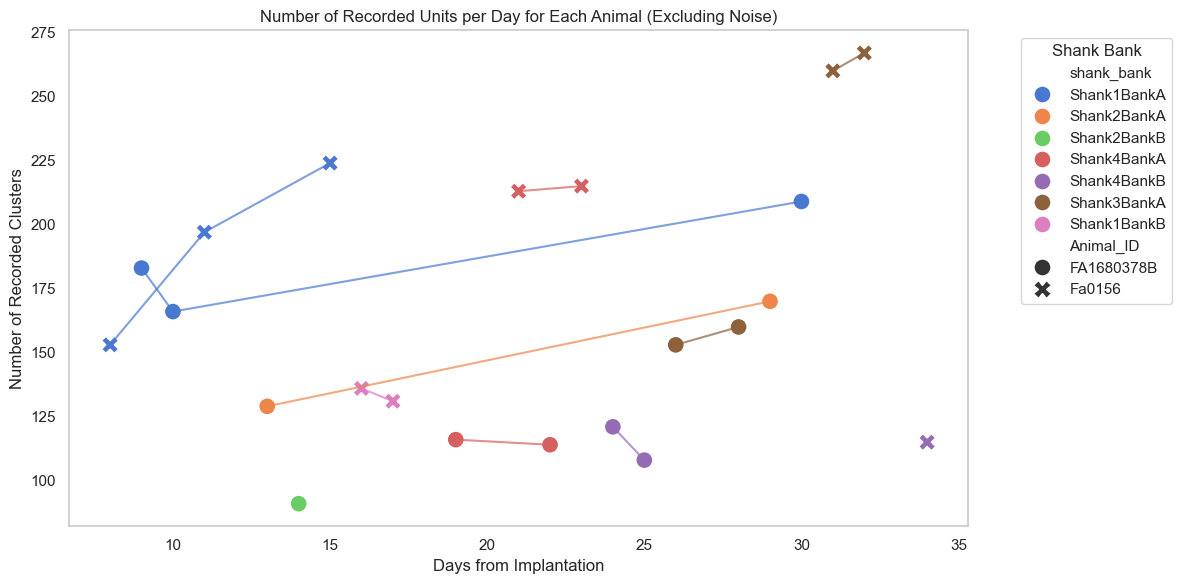

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter out noise clusters
filtered_df = concatenated_cluster_df[concatenated_cluster_df['group'] != 'noise']

# Step 2: Group the data to count the number of recorded units per day (excluding noise)
cluster_counts = filtered_df.groupby(
    ['Animal_ID', 'Days_From_Implantation', 'shank_bank']
).size().reset_index(name='Cluster_Count')

# Step 3: Set up the plot style
sns.set(style="whitegrid", palette="muted", rc={"axes.grid": False})
plt.figure(figsize=(12, 6))

# Step 4: Plot scatter plot first to ensure markers are visible and legend is correct
scatter = sns.scatterplot(
    data=cluster_counts,
    x="Days_From_Implantation",
    y="Cluster_Count",
    hue="shank_bank",  # Color by shank_bank
    style="Animal_ID",  # Style by Animal_ID
    s=150,  # Marker size
    legend="brief"  # Keep a clean legend
)

# Step 5: Overlay line plot to connect points
sns.lineplot(
    data=cluster_counts,
    x="Days_From_Implantation",
    y="Cluster_Count",
    hue="shank_bank",  # Reuse hue for same colors
    style="Animal_ID",  # Style for animals
    dashes=False,       # Solid lines
    alpha=0.7,          # Transparency for clarity
    legend=False        # Avoid duplicate legends
)

# Step 6: Add plot details
plt.title("Number of Recorded Units per Day for Each Animal (Excluding Noise)")
plt.xlabel("Days from Implantation")
plt.ylabel("Number of Recorded Clusters")

# Adjust the legend placement
plt.legend(title="Shank Bank", bbox_to_anchor=(1.05, 1), loc="upper left")

# Step 7: Adjust layout and show the plot
plt.tight_layout()
plt.show()



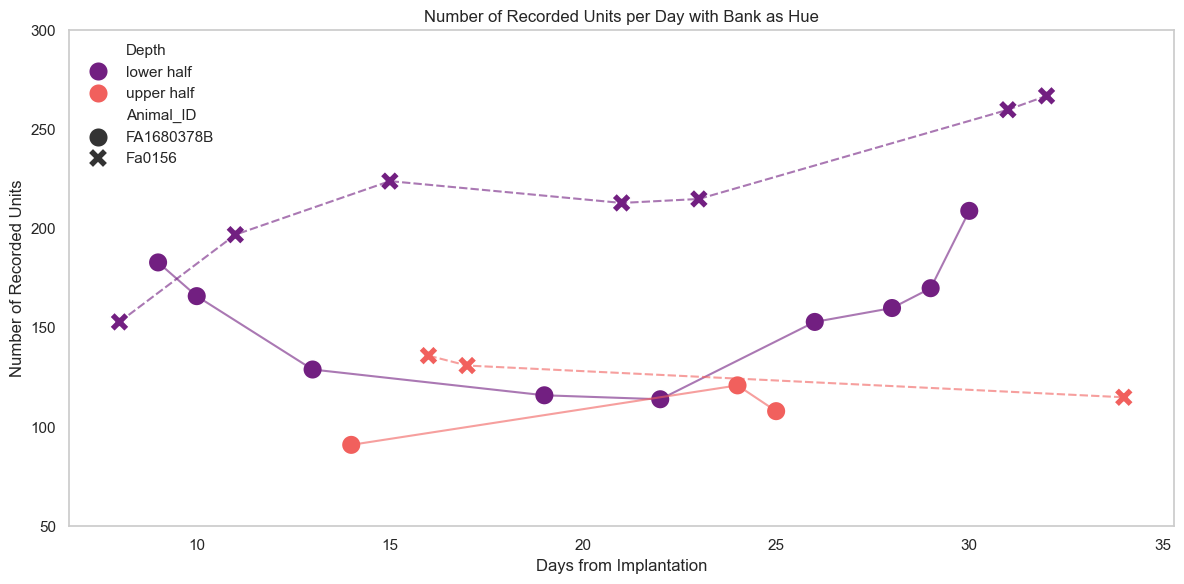

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Group the data to count the number of recorded units per day
filtered_df = concatenated_cluster_df[concatenated_cluster_df['group'] != 'noise']

cluster_counts = filtered_df.groupby(
    ['Animal_ID', 'Days_From_Implantation', 'chan_locY']
).size().reset_index(name='Cluster_Count')

# Step 2: Map chan_locY values to 'lower half' and 'upper half'
cluster_counts['Depth'] = cluster_counts['chan_locY'].map({
    0: 'lower half',
    2880: 'upper half'
})

# Set up the plot style and color palette, and turn off the grid
sns.set(style="whitegrid", palette="muted", rc={"axes.grid": False})
plt.figure(figsize=(12, 6))

# Step 3: Create a scatter plot for each Animal_ID, with chan_locY_category as hue
scatter = sns.scatterplot(
    data=cluster_counts,
    x="Days_From_Implantation",
    y="Cluster_Count",
    hue="Depth",
    style="Animal_ID",
    palette="magma",
    s=200  # Marker size
)

# Add connecting lines for visual clarity
sns.lineplot(
    data=cluster_counts,
    x="Days_From_Implantation",
    y="Cluster_Count",
    hue="Depth",
    palette="magma",
    legend=False,  # Avoid duplicate legends
    alpha=0.6,  # Make lines semi-transparent
    style="Animal_ID"
)

# Step 4: Add plot details
plt.title("Number of Recorded Units per Day with Bank as Hue")
plt.xlabel("Days from Implantation")
plt.ylabel("Number of Recorded Units")
plt.ylim([50,300])
# Remove the box around the legend
legend = scatter.legend_
if legend:
    legend.legendPatch.set_edgecolor('none')

plt.tight_layout()


output_file= os.path.join(root_directory,'Recorded Units')
plt.savefig(output_file+'.pdf', format='pdf')
plt.savefig(output_file+'.png', format='png')

plt.show()


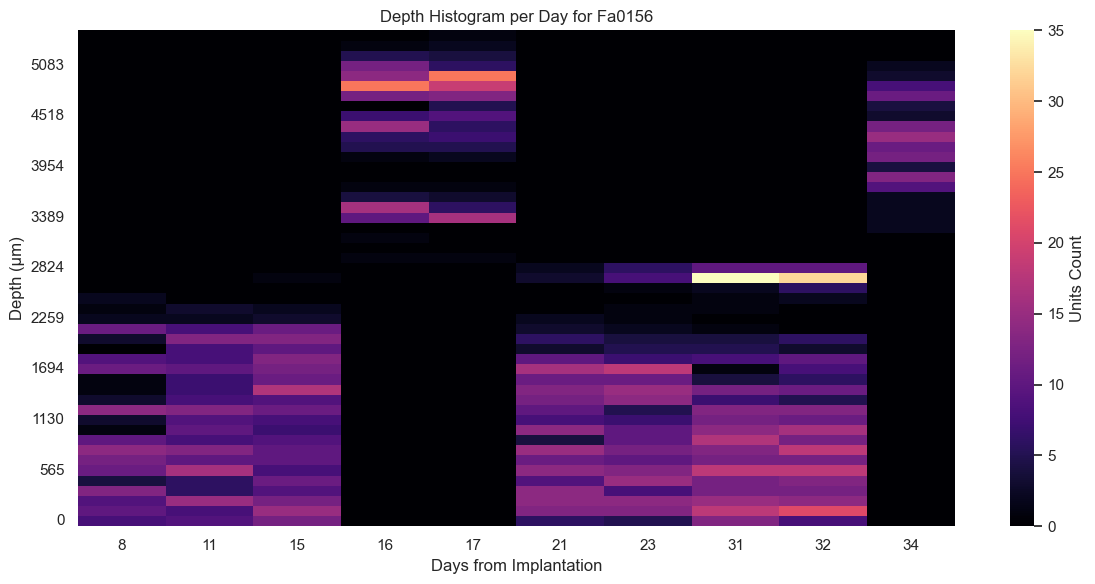

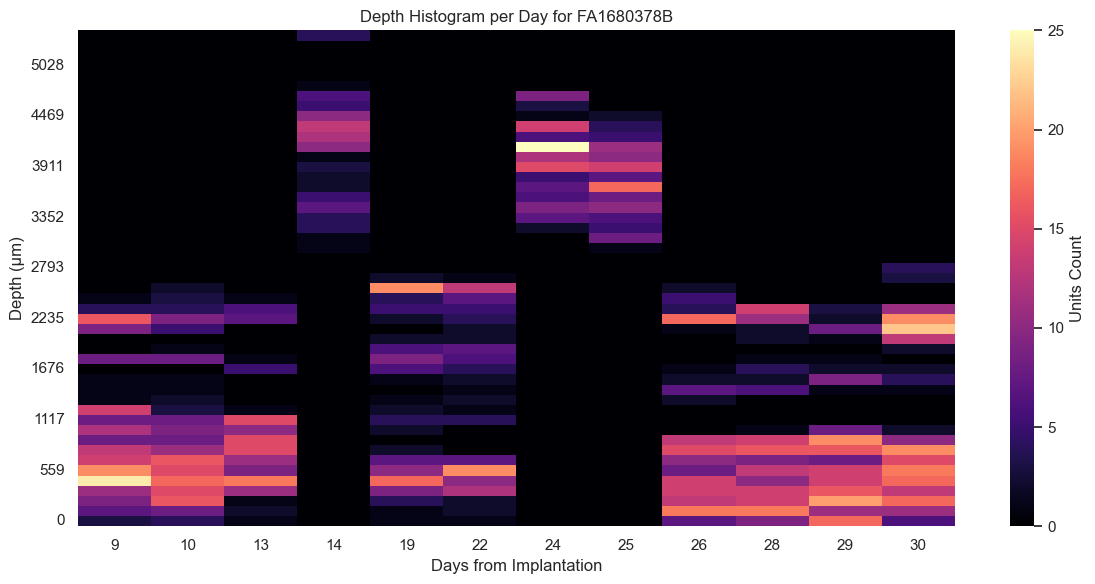

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


filtered_df = concatenated_cluster_df[concatenated_cluster_df['group'] != 'noise']

# Step 1: Iterate through each animal
for animal_id in filtered_df['Animal_ID'].unique():
    
    # Filter data for the current animal
    animal_data = filtered_df[filtered_df['Animal_ID'] == animal_id]
    
    # Step 2: Define bins for 'depth'
    depth_bins = np.linspace(animal_data['depth'].min(), animal_data['depth'].max(), 50)  # 50 bins
    days = sorted(animal_data['Days_From_Implantation'].unique())  # Sort days
    
    # Step 3: Create a matrix for the heatmap (rows: depth bins, columns: days)
    heatmap_matrix = np.zeros((len(depth_bins) - 1, len(days)))
    
    # Populate the matrix with histogram counts
    for i, day in enumerate(days):
        # Filter data for the current day
        day_data = animal_data[animal_data['Days_From_Implantation'] == day]
        
        # Histogram for 'depth' on this day
        hist, _ = np.histogram(day_data['depth'], bins=depth_bins)
        heatmap_matrix[:, i] = hist  # Add counts to the matrix
    
    # Step 4: Plot the heatmap for the current animal
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(
        heatmap_matrix, 
        cmap="magma", 
        cbar_kws={'label': 'Units Count'}, 
        xticklabels=days, 
        yticklabels=np.round(depth_bins[:-1], 2)
    )
    
    # Step 5: Reverse Y-axis and sparse the Y-tick labels
    ax.invert_yaxis()  # Reverse the Y-axis
    y_ticks = ax.get_yticks()
    sparse_ticks = y_ticks[::5]  # Show every 5th Y-tick
    sparse_labels = [f"{depth_bins[int(i)]:.0f}" for i in sparse_ticks if i < len(depth_bins)]
    ax.set_yticks(sparse_ticks)
    ax.set_yticklabels(sparse_labels)

    # Step 6: Add plot details
    plt.title(f"Depth Histogram per Day for {animal_id}")
    plt.xlabel("Days from Implantation")
    plt.ylabel("Depth (µm)")
    plt.tight_layout()
    output_file= os.path.join(root_directory,animal_id+'_Depth Histogram')
    plt.savefig(output_file+'.pdf', format='pdf')
    plt.savefig(output_file+'.png', format='png')
    # Show the plot
    plt.show()


C:\Users\saeedi\AppData\Local\Temp\ipykernel_24136\1551482081.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animal_data['chan_locX_mapped'] = animal_data['chan_locX'].map(chan_locX_map)


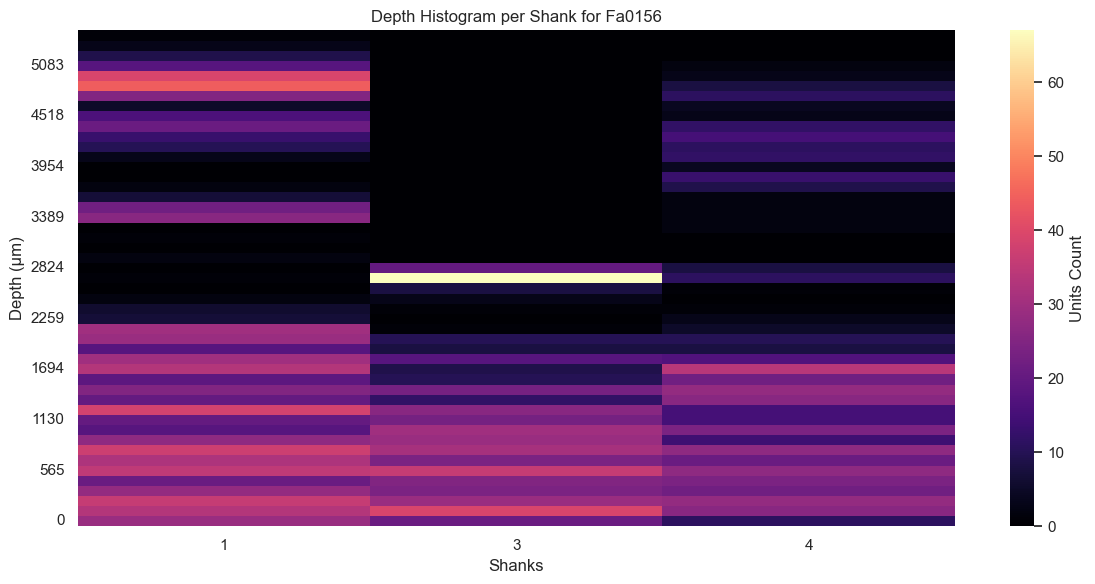

C:\Users\saeedi\AppData\Local\Temp\ipykernel_24136\1551482081.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animal_data['chan_locX_mapped'] = animal_data['chan_locX'].map(chan_locX_map)


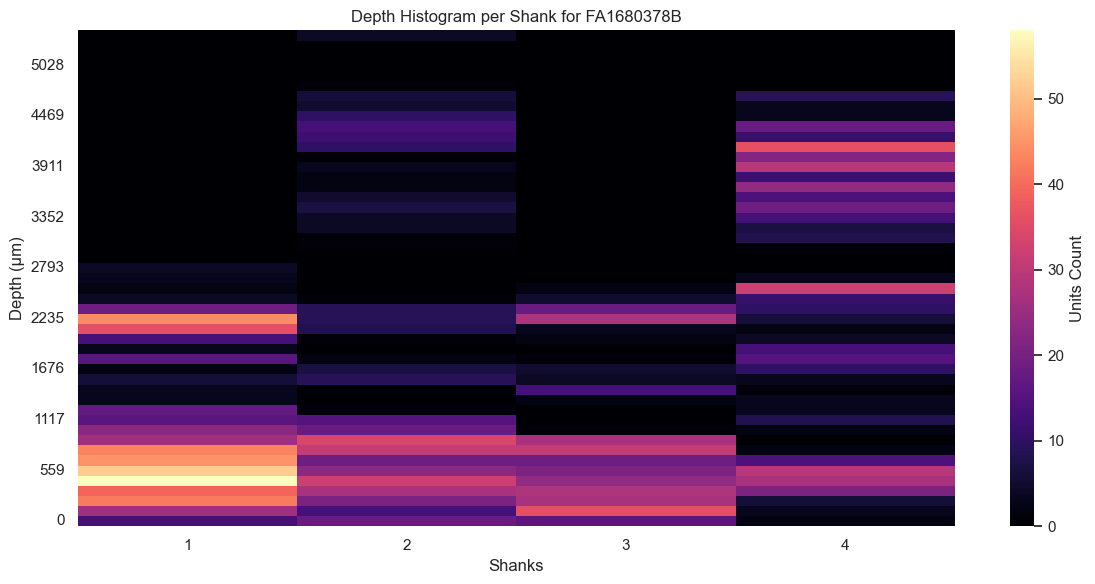

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter out noise clusters
filtered_df = concatenated_cluster_df[concatenated_cluster_df['group'] != 'noise']

# Step 1: Iterate through each animal
for animal_id in filtered_df['Animal_ID'].unique():
    
    # Filter data for the current animal
    animal_data = filtered_df[filtered_df['Animal_ID'] == animal_id]
    
    # Step 2: Define bins for 'depth'
    depth_bins = np.linspace(animal_data['depth'].min(), animal_data['depth'].max(), 50)  # 50 bins for depth
    chan_locX_values = sorted(animal_data['chan_locX'].unique())  # Unique chan_locX values
    
    # Map chan_locX values to 1, 2, 3, 4
    chan_locX_map = {0: 1, 250: 2, 500: 3, 750: 4}
    animal_data['chan_locX_mapped'] = animal_data['chan_locX'].map(chan_locX_map)
    chan_locX_mapped_values = sorted(animal_data['chan_locX_mapped'].unique())
    
    # Step 3: Create a matrix for the heatmap (rows: depth bins, columns: chan_locX_mapped)
    heatmap_matrix = np.zeros((len(depth_bins) - 1, len(chan_locX_mapped_values)))
    
    # Populate the matrix with histogram counts
    for i, chan_x in enumerate(chan_locX_mapped_values):
        # Filter data for the current chan_locX_mapped value
        shank_data = animal_data[animal_data['chan_locX_mapped'] == chan_x]
        
        # Histogram for 'depth' in this shank
        hist, _ = np.histogram(shank_data['depth'], bins=depth_bins)
        heatmap_matrix[:, i] = hist  # Add counts to the matrix
    
    # Step 4: Plot the heatmap for the current animal
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(
        heatmap_matrix, 
        cmap="magma", 
        cbar_kws={'label': 'Units Count'}, 
        xticklabels=chan_locX_mapped_values,  # Set x-tick labels as mapped chan_locX values
        yticklabels=np.round(depth_bins[:-1], 2)
    )
    
    # Step 5: Reverse Y-axis and sparse the Y-tick labels
    ax.invert_yaxis()  # Reverse the Y-axis
    y_ticks = ax.get_yticks()
    sparse_ticks = y_ticks[::5]  # Show every 5th Y-tick
    sparse_labels = [f"{depth_bins[int(i)]:.0f}" for i in sparse_ticks if i < len(depth_bins)]
    ax.set_yticks(sparse_ticks)
    ax.set_yticklabels(sparse_labels)

    # Step 6: Add plot details
    plt.title(f"Depth Histogram per Shank for {animal_id}")
    plt.xlabel("Shanks")
    plt.ylabel("Depth (µm)")
    plt.tight_layout()
    output_file= os.path.join(root_directory,animal_id+'_Depth Histogram_shank')
    plt.savefig(output_file+'.pdf', format='pdf')
    plt.savefig(output_file+'.png', format='png')
    # Show the plot
    plt.show()
